# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [136]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL'
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

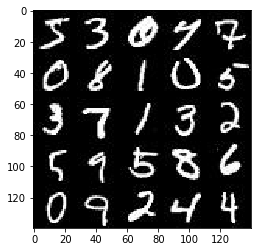

In [137]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

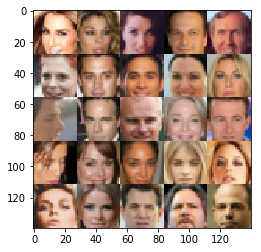

In [138]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [139]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [140]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "D:\\apps\\Anaconda3\\envs\\tensorflow_gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "D:\\apps\\Anaconda3\\envs\\tensorflow_gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "D:\\apps\\Anaconda3\\envs\\tensorflow_gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "D:\\apps\\Anaconda3\\envs\\tensorflow_gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "D:\\apps\\Anaconda3\\envs\\tensorflow_gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "D:\

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [141]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
       
        
    alpha = 0.01
    keep_prob = 0.5
        
    with tf.variable_scope('discriminator', reuse=reuse):
        
        '''
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)

        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        '''
        
      
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * x1, x1)
     
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
     
    
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
       
        
        
        return out, logits
        



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [142]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
      #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same', kernel_initializer=kernel_initializer)
        #x3 = tf.layers.batch_normalization(x3, training = is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        #drop3 = tf.nn.dropout(x3, keep_prob=keep_prob)
    
    alpha = 0.02
    keep_prob = 0.5
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        '''
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        
        x2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=1,padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        drop2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        drop3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        #x4 = tf.layers.conv2d_transpose(drop3, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x4 = tf.layers.batch_normalization(x3, training=is_train)
        #x4 = tf.maximum(alpha * x3, x3)
        #drop4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(drop3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        '''
        
     
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7,7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01*x1, x1)
      
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01*x2, x2)
   
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.01*x3, x3)
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
      
        out = tf.tanh(logits)
      
        
        
        return out
 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [143]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
        
    smooth = 0.1   
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)  * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [144]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [145]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [146]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    iteration = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
            
                iteration += 1
             
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if iteration % 100 == 0:
                    
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)

                if iteration % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [111]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))


with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.5048... Generator Loss: 0.5465
Epoch 0/1... Discriminator Loss: 0.9655... Generator Loss: 0.9580
Epoch 0/1... Discriminator Loss: 0.6688... Generator Loss: 1.6565
Epoch 0/1... Discriminator Loss: 0.5843... Generator Loss: 1.7352
Epoch 0/1... Discriminator Loss: 0.5928... Generator Loss: 1.9373
Epoch 0/1... Discriminator Loss: 0.4810... Generator Loss: 2.7471
Epoch 0/1... Discriminator Loss: 0.5133... Generator Loss: 2.2541
Epoch 0/1... Discriminator Loss: 0.4906... Generator Loss: 2.2641
Epoch 0/1... Discriminator Loss: 0.4160... Generator Loss: 3.5864


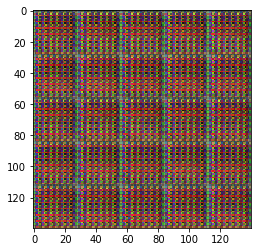

Epoch 0/1... Discriminator Loss: 0.4690... Generator Loss: 2.5910
Epoch 0/1... Discriminator Loss: 1.1741... Generator Loss: 0.6728
Epoch 0/1... Discriminator Loss: 0.4533... Generator Loss: 3.3544
Epoch 0/1... Discriminator Loss: 0.5957... Generator Loss: 3.4767
Epoch 0/1... Discriminator Loss: 0.5647... Generator Loss: 1.9375
Epoch 0/1... Discriminator Loss: 0.4050... Generator Loss: 3.7211
Epoch 0/1... Discriminator Loss: 0.5451... Generator Loss: 2.3161
Epoch 0/1... Discriminator Loss: 0.4704... Generator Loss: 2.8511
Epoch 0/1... Discriminator Loss: 0.4735... Generator Loss: 2.6474
Epoch 0/1... Discriminator Loss: 0.7729... Generator Loss: 2.5329


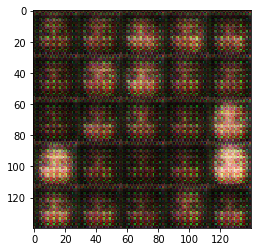

Epoch 0/1... Discriminator Loss: 0.8604... Generator Loss: 1.4975
Epoch 0/1... Discriminator Loss: 0.6988... Generator Loss: 1.8170
Epoch 0/1... Discriminator Loss: 0.8559... Generator Loss: 1.2138
Epoch 0/1... Discriminator Loss: 1.1103... Generator Loss: 4.2742
Epoch 0/1... Discriminator Loss: 0.7302... Generator Loss: 1.6605
Epoch 0/1... Discriminator Loss: 0.6352... Generator Loss: 2.2985
Epoch 0/1... Discriminator Loss: 0.6939... Generator Loss: 1.7404
Epoch 0/1... Discriminator Loss: 0.7264... Generator Loss: 1.5248
Epoch 0/1... Discriminator Loss: 0.8379... Generator Loss: 1.6613
Epoch 0/1... Discriminator Loss: 0.7829... Generator Loss: 1.3117


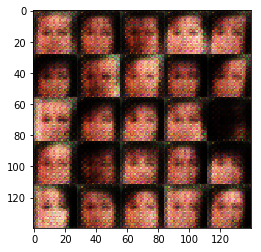

Epoch 0/1... Discriminator Loss: 0.9703... Generator Loss: 0.8859
Epoch 0/1... Discriminator Loss: 0.9870... Generator Loss: 1.0575
Epoch 0/1... Discriminator Loss: 0.7471... Generator Loss: 2.2347
Epoch 0/1... Discriminator Loss: 0.6846... Generator Loss: 2.6429
Epoch 0/1... Discriminator Loss: 0.8181... Generator Loss: 1.4213
Epoch 0/1... Discriminator Loss: 0.7166... Generator Loss: 2.6936
Epoch 0/1... Discriminator Loss: 0.9051... Generator Loss: 1.3417
Epoch 0/1... Discriminator Loss: 0.9944... Generator Loss: 1.0120
Epoch 0/1... Discriminator Loss: 1.1259... Generator Loss: 0.8512
Epoch 0/1... Discriminator Loss: 0.6498... Generator Loss: 1.8329


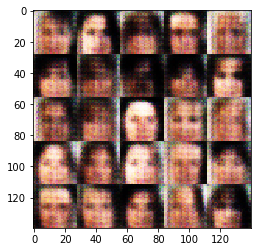

Epoch 0/1... Discriminator Loss: 0.9968... Generator Loss: 1.0635
Epoch 0/1... Discriminator Loss: 0.9560... Generator Loss: 1.1913
Epoch 0/1... Discriminator Loss: 0.8563... Generator Loss: 1.8042
Epoch 0/1... Discriminator Loss: 1.1687... Generator Loss: 0.7429
Epoch 0/1... Discriminator Loss: 0.8856... Generator Loss: 1.2706
Epoch 0/1... Discriminator Loss: 0.8349... Generator Loss: 1.2101
Epoch 0/1... Discriminator Loss: 0.8604... Generator Loss: 1.2035
Epoch 0/1... Discriminator Loss: 0.9433... Generator Loss: 1.4213
Epoch 0/1... Discriminator Loss: 0.8144... Generator Loss: 1.2846
Epoch 0/1... Discriminator Loss: 0.9387... Generator Loss: 1.0886


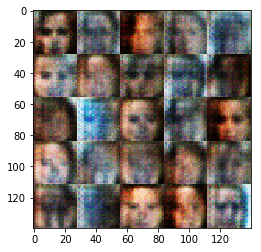

Epoch 0/1... Discriminator Loss: 0.6829... Generator Loss: 1.6461
Epoch 0/1... Discriminator Loss: 1.2359... Generator Loss: 0.8479
Epoch 0/1... Discriminator Loss: 0.9457... Generator Loss: 1.4800
Epoch 0/1... Discriminator Loss: 1.0506... Generator Loss: 0.9323
Epoch 0/1... Discriminator Loss: 1.1880... Generator Loss: 0.7299
Epoch 0/1... Discriminator Loss: 1.2399... Generator Loss: 0.6084
Epoch 0/1... Discriminator Loss: 0.8450... Generator Loss: 1.2238
Epoch 0/1... Discriminator Loss: 0.7483... Generator Loss: 2.4515
Epoch 0/1... Discriminator Loss: 0.9419... Generator Loss: 1.4682
Epoch 0/1... Discriminator Loss: 0.8662... Generator Loss: 1.7546


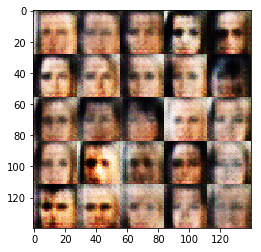

Epoch 0/1... Discriminator Loss: 0.8440... Generator Loss: 1.7097
Epoch 0/1... Discriminator Loss: 1.0228... Generator Loss: 1.2377
Epoch 0/1... Discriminator Loss: 0.9955... Generator Loss: 1.5608
Epoch 0/1... Discriminator Loss: 1.0296... Generator Loss: 1.5746
Epoch 0/1... Discriminator Loss: 1.1241... Generator Loss: 1.4944
Epoch 0/1... Discriminator Loss: 1.0091... Generator Loss: 1.2384
Epoch 0/1... Discriminator Loss: 1.0974... Generator Loss: 2.1911
Epoch 0/1... Discriminator Loss: 1.2986... Generator Loss: 1.7892
Epoch 0/1... Discriminator Loss: 1.0156... Generator Loss: 1.1658
Epoch 0/1... Discriminator Loss: 1.0469... Generator Loss: 1.2504


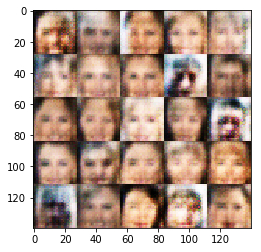

Epoch 0/1... Discriminator Loss: 1.0155... Generator Loss: 1.3132
Epoch 0/1... Discriminator Loss: 1.0780... Generator Loss: 1.4758
Epoch 0/1... Discriminator Loss: 1.1658... Generator Loss: 0.8144
Epoch 0/1... Discriminator Loss: 1.0048... Generator Loss: 1.1647
Epoch 0/1... Discriminator Loss: 0.8994... Generator Loss: 1.0984
Epoch 0/1... Discriminator Loss: 0.9923... Generator Loss: 1.1910
Epoch 0/1... Discriminator Loss: 1.1163... Generator Loss: 0.9395
Epoch 0/1... Discriminator Loss: 0.8852... Generator Loss: 1.6496
Epoch 0/1... Discriminator Loss: 1.0643... Generator Loss: 0.8028
Epoch 0/1... Discriminator Loss: 1.0726... Generator Loss: 1.0497


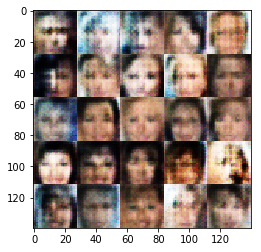

Epoch 0/1... Discriminator Loss: 0.9573... Generator Loss: 1.4690
Epoch 0/1... Discriminator Loss: 1.1231... Generator Loss: 0.8848
Epoch 0/1... Discriminator Loss: 1.0164... Generator Loss: 1.1477
Epoch 0/1... Discriminator Loss: 1.1957... Generator Loss: 0.8077
Epoch 0/1... Discriminator Loss: 1.0824... Generator Loss: 0.8826
Epoch 0/1... Discriminator Loss: 0.8850... Generator Loss: 1.4730
Epoch 0/1... Discriminator Loss: 1.0710... Generator Loss: 1.0523
Epoch 0/1... Discriminator Loss: 1.1375... Generator Loss: 0.8113
Epoch 0/1... Discriminator Loss: 1.0479... Generator Loss: 0.9091
Epoch 0/1... Discriminator Loss: 1.1837... Generator Loss: 1.1445


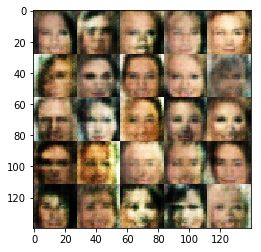

Epoch 0/1... Discriminator Loss: 1.0183... Generator Loss: 0.9747
Epoch 0/1... Discriminator Loss: 1.0073... Generator Loss: 1.2137
Epoch 0/1... Discriminator Loss: 1.2485... Generator Loss: 0.7722
Epoch 0/1... Discriminator Loss: 1.0881... Generator Loss: 1.4056
Epoch 0/1... Discriminator Loss: 0.9533... Generator Loss: 1.9093
Epoch 0/1... Discriminator Loss: 1.0052... Generator Loss: 0.9785
Epoch 0/1... Discriminator Loss: 1.1548... Generator Loss: 0.8189
Epoch 0/1... Discriminator Loss: 1.0219... Generator Loss: 1.3315
Epoch 0/1... Discriminator Loss: 1.1550... Generator Loss: 0.7980
Epoch 0/1... Discriminator Loss: 1.0000... Generator Loss: 1.2640


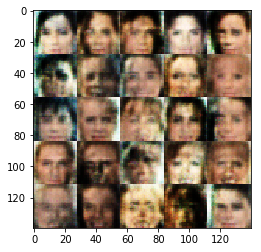

Epoch 0/1... Discriminator Loss: 1.0228... Generator Loss: 1.0026
Epoch 0/1... Discriminator Loss: 1.1683... Generator Loss: 1.0057
Epoch 0/1... Discriminator Loss: 1.3202... Generator Loss: 0.6233
Epoch 0/1... Discriminator Loss: 0.9984... Generator Loss: 1.2200
Epoch 0/1... Discriminator Loss: 0.9710... Generator Loss: 1.2142
Epoch 0/1... Discriminator Loss: 1.1191... Generator Loss: 1.2924
Epoch 0/1... Discriminator Loss: 1.0594... Generator Loss: 1.1195
Epoch 0/1... Discriminator Loss: 1.1363... Generator Loss: 0.8473
Epoch 0/1... Discriminator Loss: 1.0405... Generator Loss: 1.2198
Epoch 0/1... Discriminator Loss: 1.2215... Generator Loss: 0.7169


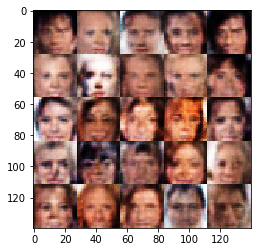

Epoch 0/1... Discriminator Loss: 1.0047... Generator Loss: 1.0985
Epoch 0/1... Discriminator Loss: 1.1899... Generator Loss: 1.0388
Epoch 0/1... Discriminator Loss: 1.0456... Generator Loss: 1.5623
Epoch 0/1... Discriminator Loss: 0.9900... Generator Loss: 1.0464
Epoch 0/1... Discriminator Loss: 1.1420... Generator Loss: 1.6305
Epoch 0/1... Discriminator Loss: 1.2761... Generator Loss: 0.7025
Epoch 0/1... Discriminator Loss: 1.1385... Generator Loss: 0.9169
Epoch 0/1... Discriminator Loss: 1.1583... Generator Loss: 0.8805
Epoch 0/1... Discriminator Loss: 1.1952... Generator Loss: 0.7354
Epoch 0/1... Discriminator Loss: 1.1968... Generator Loss: 0.9755


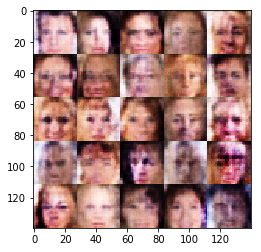

Epoch 0/1... Discriminator Loss: 0.8504... Generator Loss: 1.9072
Epoch 0/1... Discriminator Loss: 1.2255... Generator Loss: 0.7378
Epoch 0/1... Discriminator Loss: 1.0594... Generator Loss: 0.8842
Epoch 0/1... Discriminator Loss: 0.9751... Generator Loss: 1.0878
Epoch 0/1... Discriminator Loss: 1.3821... Generator Loss: 0.5640
Epoch 0/1... Discriminator Loss: 1.1498... Generator Loss: 1.2756
Epoch 0/1... Discriminator Loss: 0.9474... Generator Loss: 1.3787
Epoch 0/1... Discriminator Loss: 1.1714... Generator Loss: 1.4382
Epoch 0/1... Discriminator Loss: 1.3313... Generator Loss: 0.6270
Epoch 0/1... Discriminator Loss: 1.1366... Generator Loss: 1.6142


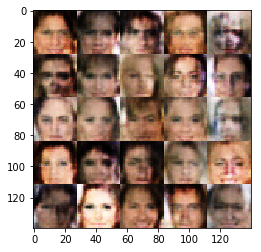

Epoch 0/1... Discriminator Loss: 1.0504... Generator Loss: 0.7970
Epoch 0/1... Discriminator Loss: 1.0427... Generator Loss: 1.3213
Epoch 0/1... Discriminator Loss: 1.3092... Generator Loss: 0.6013
Epoch 0/1... Discriminator Loss: 1.0080... Generator Loss: 1.2419
Epoch 0/1... Discriminator Loss: 1.0223... Generator Loss: 1.2759
Epoch 0/1... Discriminator Loss: 1.1405... Generator Loss: 0.7885
Epoch 0/1... Discriminator Loss: 1.0272... Generator Loss: 1.3011
Epoch 0/1... Discriminator Loss: 1.0949... Generator Loss: 0.8644
Epoch 0/1... Discriminator Loss: 1.0945... Generator Loss: 1.1825
Epoch 0/1... Discriminator Loss: 1.1120... Generator Loss: 1.1811


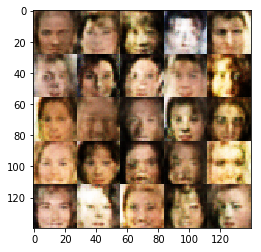

Epoch 0/1... Discriminator Loss: 0.9500... Generator Loss: 1.2826
Epoch 0/1... Discriminator Loss: 1.2283... Generator Loss: 0.7511
Epoch 0/1... Discriminator Loss: 1.0082... Generator Loss: 1.2980
Epoch 0/1... Discriminator Loss: 1.0933... Generator Loss: 0.7799
Epoch 0/1... Discriminator Loss: 0.9649... Generator Loss: 1.0476
Epoch 0/1... Discriminator Loss: 1.2142... Generator Loss: 0.8023
Epoch 0/1... Discriminator Loss: 1.1180... Generator Loss: 1.5556
Epoch 0/1... Discriminator Loss: 1.0657... Generator Loss: 0.9131
Epoch 0/1... Discriminator Loss: 1.0699... Generator Loss: 1.1993
Epoch 0/1... Discriminator Loss: 1.1842... Generator Loss: 0.8010


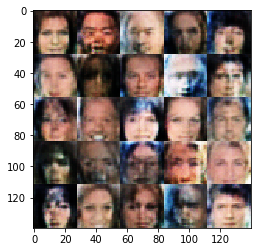

Epoch 0/1... Discriminator Loss: 1.1385... Generator Loss: 0.9648
Epoch 0/1... Discriminator Loss: 1.0143... Generator Loss: 1.1322
Epoch 0/1... Discriminator Loss: 1.1409... Generator Loss: 0.7754
Epoch 0/1... Discriminator Loss: 1.0825... Generator Loss: 1.1310
Epoch 0/1... Discriminator Loss: 1.1588... Generator Loss: 1.0308
Epoch 0/1... Discriminator Loss: 1.2128... Generator Loss: 0.7595
Epoch 0/1... Discriminator Loss: 1.1457... Generator Loss: 0.8919
Epoch 0/1... Discriminator Loss: 1.1222... Generator Loss: 1.1143
Epoch 0/1... Discriminator Loss: 1.0577... Generator Loss: 1.0970
Epoch 0/1... Discriminator Loss: 1.3222... Generator Loss: 1.5923


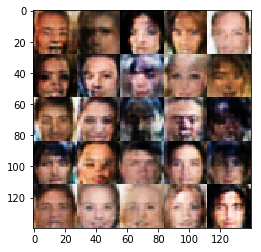

Epoch 0/1... Discriminator Loss: 1.0485... Generator Loss: 1.1279
Epoch 0/1... Discriminator Loss: 1.0565... Generator Loss: 0.9150
Epoch 0/1... Discriminator Loss: 0.9869... Generator Loss: 1.0816
Epoch 0/1... Discriminator Loss: 1.0410... Generator Loss: 1.2361
Epoch 0/1... Discriminator Loss: 1.1508... Generator Loss: 0.7888
Epoch 0/1... Discriminator Loss: 1.0242... Generator Loss: 1.7434
Epoch 0/1... Discriminator Loss: 1.1600... Generator Loss: 0.7797
Epoch 0/1... Discriminator Loss: 1.4549... Generator Loss: 0.5052
Epoch 0/1... Discriminator Loss: 1.0154... Generator Loss: 1.0693
Epoch 0/1... Discriminator Loss: 1.2299... Generator Loss: 0.6396


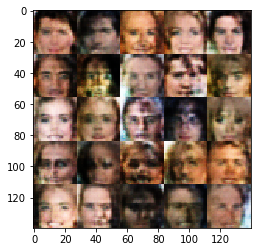

Epoch 0/1... Discriminator Loss: 1.1084... Generator Loss: 0.8522
Epoch 0/1... Discriminator Loss: 0.7982... Generator Loss: 1.7669
Epoch 0/1... Discriminator Loss: 1.3540... Generator Loss: 0.7473
Epoch 0/1... Discriminator Loss: 1.2237... Generator Loss: 1.7017
Epoch 0/1... Discriminator Loss: 1.0997... Generator Loss: 1.1264
Epoch 0/1... Discriminator Loss: 1.0534... Generator Loss: 1.0757
Epoch 0/1... Discriminator Loss: 1.0013... Generator Loss: 1.3534
Epoch 0/1... Discriminator Loss: 1.2249... Generator Loss: 1.1405
Epoch 0/1... Discriminator Loss: 1.1383... Generator Loss: 0.9875
Epoch 0/1... Discriminator Loss: 1.2626... Generator Loss: 0.6742


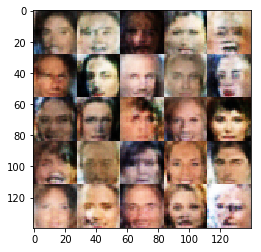

Epoch 0/1... Discriminator Loss: 1.1733... Generator Loss: 0.8617
Epoch 0/1... Discriminator Loss: 1.1935... Generator Loss: 0.9021
Epoch 0/1... Discriminator Loss: 1.0764... Generator Loss: 0.8986
Epoch 0/1... Discriminator Loss: 1.0070... Generator Loss: 1.2248
Epoch 0/1... Discriminator Loss: 1.1699... Generator Loss: 0.7281
Epoch 0/1... Discriminator Loss: 1.3655... Generator Loss: 0.5855
Epoch 0/1... Discriminator Loss: 0.9841... Generator Loss: 0.9789
Epoch 0/1... Discriminator Loss: 1.0294... Generator Loss: 0.8136
Epoch 0/1... Discriminator Loss: 1.2372... Generator Loss: 0.7626
Epoch 0/1... Discriminator Loss: 0.9649... Generator Loss: 2.3400


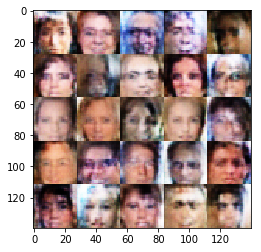

Epoch 0/1... Discriminator Loss: 1.2785... Generator Loss: 0.6891
Epoch 0/1... Discriminator Loss: 1.1349... Generator Loss: 0.7697
Epoch 0/1... Discriminator Loss: 1.1391... Generator Loss: 0.9459
Epoch 0/1... Discriminator Loss: 1.1146... Generator Loss: 0.8873
Epoch 0/1... Discriminator Loss: 1.2175... Generator Loss: 0.7560
Epoch 0/1... Discriminator Loss: 1.1321... Generator Loss: 0.8281
Epoch 0/1... Discriminator Loss: 1.2256... Generator Loss: 0.8629
Epoch 0/1... Discriminator Loss: 1.2263... Generator Loss: 0.8541
Epoch 0/1... Discriminator Loss: 0.9176... Generator Loss: 1.0015
Epoch 0/1... Discriminator Loss: 1.2508... Generator Loss: 0.6534


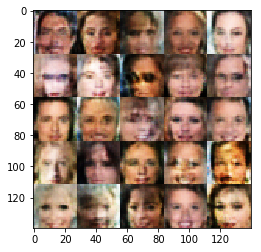

Epoch 0/1... Discriminator Loss: 1.1206... Generator Loss: 1.4172
Epoch 0/1... Discriminator Loss: 1.1015... Generator Loss: 0.8841
Epoch 0/1... Discriminator Loss: 1.1872... Generator Loss: 0.7118
Epoch 0/1... Discriminator Loss: 1.0869... Generator Loss: 1.2262
Epoch 0/1... Discriminator Loss: 1.3335... Generator Loss: 0.5844
Epoch 0/1... Discriminator Loss: 0.9901... Generator Loss: 1.2085
Epoch 0/1... Discriminator Loss: 1.1802... Generator Loss: 0.7583
Epoch 0/1... Discriminator Loss: 1.3348... Generator Loss: 0.5600
Epoch 0/1... Discriminator Loss: 1.1155... Generator Loss: 1.0966
Epoch 0/1... Discriminator Loss: 1.2441... Generator Loss: 0.6899


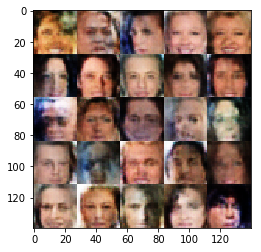

Epoch 0/1... Discriminator Loss: 1.0952... Generator Loss: 0.9608
Epoch 0/1... Discriminator Loss: 1.0502... Generator Loss: 1.1678
Epoch 0/1... Discriminator Loss: 1.1009... Generator Loss: 0.7953
Epoch 0/1... Discriminator Loss: 1.0558... Generator Loss: 0.8271
Epoch 0/1... Discriminator Loss: 1.1830... Generator Loss: 0.8063
Epoch 0/1... Discriminator Loss: 1.0429... Generator Loss: 1.2226
Epoch 0/1... Discriminator Loss: 1.3248... Generator Loss: 0.7304
Epoch 0/1... Discriminator Loss: 1.0447... Generator Loss: 1.5014
Epoch 0/1... Discriminator Loss: 1.3177... Generator Loss: 1.0891
Epoch 0/1... Discriminator Loss: 1.2297... Generator Loss: 0.7447


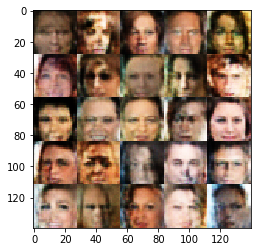

Epoch 0/1... Discriminator Loss: 1.0910... Generator Loss: 0.9863
Epoch 0/1... Discriminator Loss: 1.2046... Generator Loss: 0.7362
Epoch 0/1... Discriminator Loss: 1.1268... Generator Loss: 0.7732
Epoch 0/1... Discriminator Loss: 1.2354... Generator Loss: 0.9112
Epoch 0/1... Discriminator Loss: 1.1634... Generator Loss: 0.9557
Epoch 0/1... Discriminator Loss: 1.0853... Generator Loss: 1.0942
Epoch 0/1... Discriminator Loss: 0.8754... Generator Loss: 1.5231
Epoch 0/1... Discriminator Loss: 1.2843... Generator Loss: 0.5926
Epoch 0/1... Discriminator Loss: 0.9966... Generator Loss: 1.1240
Epoch 0/1... Discriminator Loss: 1.0331... Generator Loss: 0.9433


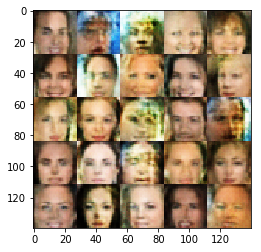

Epoch 0/1... Discriminator Loss: 0.8586... Generator Loss: 1.7167
Epoch 0/1... Discriminator Loss: 1.1652... Generator Loss: 0.9989
Epoch 0/1... Discriminator Loss: 1.1303... Generator Loss: 0.8896
Epoch 0/1... Discriminator Loss: 0.9407... Generator Loss: 1.2372
Epoch 0/1... Discriminator Loss: 1.2776... Generator Loss: 0.5915
Epoch 0/1... Discriminator Loss: 1.0217... Generator Loss: 0.8014
Epoch 0/1... Discriminator Loss: 1.0223... Generator Loss: 1.1769
Epoch 0/1... Discriminator Loss: 1.1932... Generator Loss: 0.7982
Epoch 0/1... Discriminator Loss: 0.9983... Generator Loss: 0.9871
Epoch 0/1... Discriminator Loss: 0.9108... Generator Loss: 1.2842


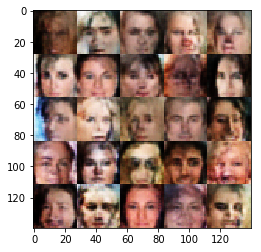

Epoch 0/1... Discriminator Loss: 0.9618... Generator Loss: 0.9666
Epoch 0/1... Discriminator Loss: 1.0936... Generator Loss: 0.9503
Epoch 0/1... Discriminator Loss: 0.9002... Generator Loss: 1.1332
Epoch 0/1... Discriminator Loss: 0.9554... Generator Loss: 1.1634
Epoch 0/1... Discriminator Loss: 1.5305... Generator Loss: 0.4402
Epoch 0/1... Discriminator Loss: 0.8589... Generator Loss: 1.9993
Epoch 0/1... Discriminator Loss: 1.4426... Generator Loss: 0.5086
Epoch 0/1... Discriminator Loss: 1.1007... Generator Loss: 1.1340
Epoch 0/1... Discriminator Loss: 0.9544... Generator Loss: 1.1892
Epoch 0/1... Discriminator Loss: 1.1105... Generator Loss: 1.0816


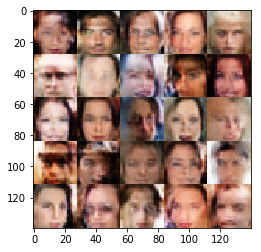

Epoch 0/1... Discriminator Loss: 0.9924... Generator Loss: 1.1781
Epoch 0/1... Discriminator Loss: 1.1755... Generator Loss: 1.2576
Epoch 0/1... Discriminator Loss: 1.1750... Generator Loss: 0.9469
Epoch 0/1... Discriminator Loss: 1.0012... Generator Loss: 1.1185
Epoch 0/1... Discriminator Loss: 1.1325... Generator Loss: 0.7729
Epoch 0/1... Discriminator Loss: 1.0552... Generator Loss: 0.8427
Epoch 0/1... Discriminator Loss: 1.1243... Generator Loss: 1.2967
Epoch 0/1... Discriminator Loss: 1.1394... Generator Loss: 0.8638
Epoch 0/1... Discriminator Loss: 1.2604... Generator Loss: 0.6340
Epoch 0/1... Discriminator Loss: 0.7993... Generator Loss: 1.5195


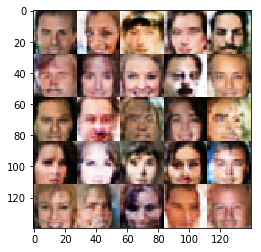

Epoch 0/1... Discriminator Loss: 1.3832... Generator Loss: 0.5692
Epoch 0/1... Discriminator Loss: 1.0936... Generator Loss: 0.9776
Epoch 0/1... Discriminator Loss: 1.3745... Generator Loss: 0.7446
Epoch 0/1... Discriminator Loss: 1.0112... Generator Loss: 1.0132
Epoch 0/1... Discriminator Loss: 1.2001... Generator Loss: 0.8580
Epoch 0/1... Discriminator Loss: 1.1935... Generator Loss: 0.7160
Epoch 0/1... Discriminator Loss: 1.1882... Generator Loss: 1.2278
Epoch 0/1... Discriminator Loss: 1.2369... Generator Loss: 0.8296
Epoch 0/1... Discriminator Loss: 1.1599... Generator Loss: 0.8588
Epoch 0/1... Discriminator Loss: 1.4839... Generator Loss: 0.4601


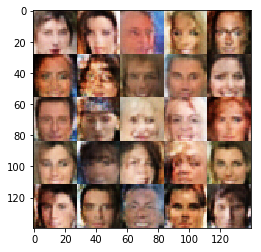

Epoch 0/1... Discriminator Loss: 0.7810... Generator Loss: 1.3399
Epoch 0/1... Discriminator Loss: 1.0816... Generator Loss: 1.0650
Epoch 0/1... Discriminator Loss: 1.4439... Generator Loss: 0.5219
Epoch 0/1... Discriminator Loss: 1.4499... Generator Loss: 0.6148
Epoch 0/1... Discriminator Loss: 1.0749... Generator Loss: 0.9962
Epoch 0/1... Discriminator Loss: 1.2804... Generator Loss: 0.7075
Epoch 0/1... Discriminator Loss: 1.0671... Generator Loss: 0.8780
Epoch 0/1... Discriminator Loss: 1.1027... Generator Loss: 0.7912
Epoch 0/1... Discriminator Loss: 1.4101... Generator Loss: 0.4975
Epoch 0/1... Discriminator Loss: 1.3914... Generator Loss: 0.7462


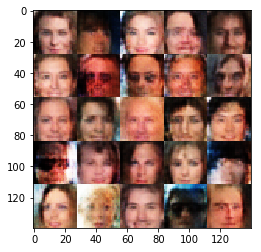

Epoch 0/1... Discriminator Loss: 1.0647... Generator Loss: 0.8520
Epoch 0/1... Discriminator Loss: 1.2496... Generator Loss: 0.7019
Epoch 0/1... Discriminator Loss: 1.0057... Generator Loss: 1.0252
Epoch 0/1... Discriminator Loss: 0.8597... Generator Loss: 1.2389
Epoch 0/1... Discriminator Loss: 1.1925... Generator Loss: 0.8145
Epoch 0/1... Discriminator Loss: 0.9774... Generator Loss: 1.3211
Epoch 0/1... Discriminator Loss: 0.9049... Generator Loss: 1.0553
Epoch 0/1... Discriminator Loss: 1.0201... Generator Loss: 1.0274
Epoch 0/1... Discriminator Loss: 1.0542... Generator Loss: 1.2055
Epoch 0/1... Discriminator Loss: 1.2990... Generator Loss: 0.8087


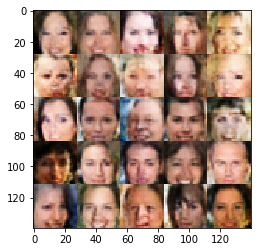

Epoch 0/1... Discriminator Loss: 1.3497... Generator Loss: 1.9700
Epoch 0/1... Discriminator Loss: 1.0339... Generator Loss: 1.0670
Epoch 0/1... Discriminator Loss: 1.0846... Generator Loss: 1.3802
Epoch 0/1... Discriminator Loss: 1.0993... Generator Loss: 0.7677
Epoch 0/1... Discriminator Loss: 1.2478... Generator Loss: 0.7221
Epoch 0/1... Discriminator Loss: 1.1150... Generator Loss: 0.7877
Epoch 0/1... Discriminator Loss: 1.1741... Generator Loss: 1.5122
Epoch 0/1... Discriminator Loss: 1.0529... Generator Loss: 0.9975
Epoch 0/1... Discriminator Loss: 1.1197... Generator Loss: 0.9296
Epoch 0/1... Discriminator Loss: 1.1584... Generator Loss: 0.8620


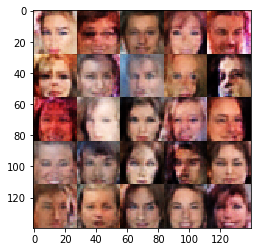

Epoch 0/1... Discriminator Loss: 1.2303... Generator Loss: 0.6636
Epoch 0/1... Discriminator Loss: 1.0060... Generator Loss: 1.0590
Epoch 0/1... Discriminator Loss: 1.1918... Generator Loss: 0.7465
Epoch 0/1... Discriminator Loss: 1.1792... Generator Loss: 1.0718
Epoch 0/1... Discriminator Loss: 1.3042... Generator Loss: 0.7777
Epoch 0/1... Discriminator Loss: 0.9976... Generator Loss: 1.3150
Epoch 0/1... Discriminator Loss: 1.3266... Generator Loss: 0.6241
Epoch 0/1... Discriminator Loss: 1.1311... Generator Loss: 0.8276
Epoch 0/1... Discriminator Loss: 1.0888... Generator Loss: 1.0608
Epoch 0/1... Discriminator Loss: 0.9860... Generator Loss: 0.9578


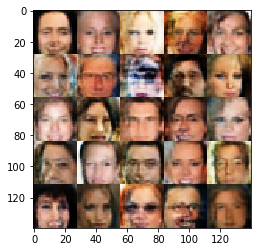

Epoch 0/1... Discriminator Loss: 1.2471... Generator Loss: 0.6148
Epoch 0/1... Discriminator Loss: 1.3152... Generator Loss: 0.6322
Epoch 0/1... Discriminator Loss: 1.1140... Generator Loss: 0.9013
Epoch 0/1... Discriminator Loss: 1.2000... Generator Loss: 0.7786
Epoch 0/1... Discriminator Loss: 0.9837... Generator Loss: 1.0863
Epoch 0/1... Discriminator Loss: 1.3260... Generator Loss: 0.6635
Epoch 0/1... Discriminator Loss: 1.3528... Generator Loss: 0.5322


In [148]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.